In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
os.chdir('/home/tapas/keras_multiclass/')
frame = pd.read_csv('train_n.csv')

In [28]:
pd.DataFrame({'Data Type': frame.dtypes, 'Null Value': pd.isnull(frame).any(), 
              'Count': list(map(lambda column: len(frame[column].unique()), frame.columns))})

,Count,Data Type,Null Value
CGPA_II,118,float64,False
CGPA_I,142,float64,False
Age,9,int64,False
Work Experience,33,int64,False
Score,44,float64,False
FMG/IMG_FMG,2,int64,False
FMG/IMG_IMG,2,int64,False
Gender_Female,2,int64,False
Gender_Male,2,int64,False
Company,4,object,False


In [22]:
frame = frame.drop('Identity',axis = 1)

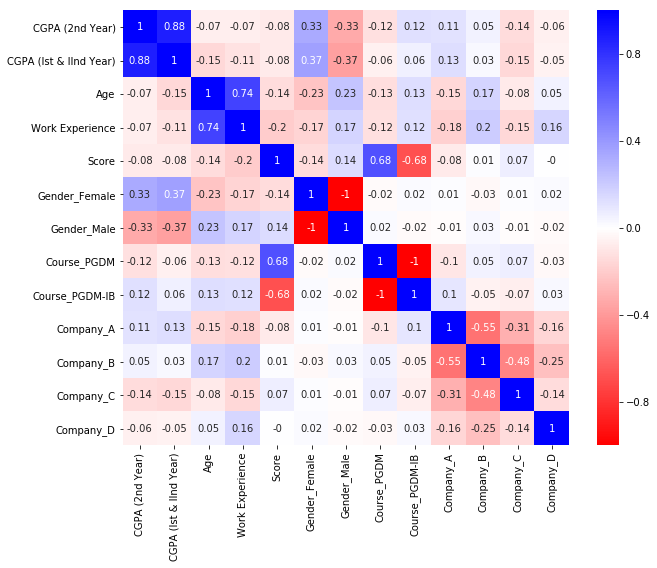

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

frame_dummy = pd.get_dummies(frame.drop('FMG/IMG', axis=1))

plt.figure(figsize=(10,8))
sns.heatmap(frame_dummy.corr().round(decimals=2), cmap='bwr_r', annot=True, vmin=-1, vmax=1)

In [29]:
from sklearn.model_selection import train_test_split

unique_cat = set(frame['Company'].unique())
frame['Company_'] = pd.Categorical(frame['Company'], categories=unique_cat).codes

y = frame['Company_']
X = frame.drop(['Company', 'Company_'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

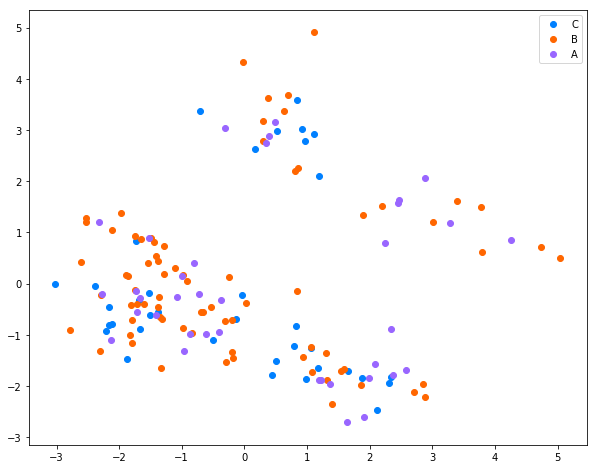

In [31]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


pca_pipe = Pipeline(steps=[('norm', StandardScaler()), ('pca', PCA(n_components=2))]).fit(X_train)
pc = pca_pipe.transform(X_train)
pc_1, pc_2 = list(zip(*pc))

groups = pd.DataFrame({'pc_1' : pc_1, 'pc_2': pc_2, 'y': y_train}).groupby('y')

plt.figure(figsize=(10,8))
for group, color, name in zip(frame['Company_'].unique(), ['#0080ff', '#ff6600', '#9966ff',''], 
                              frame['Company'].unique()):
    pc_group = groups.get_group(group)
    plt.scatter(pc_group.loc[:,'pc_1'], pc_group.loc[:,'pc_2'], color=color, label=name)
plt.legend()

roc auc score for Company_A = 0.5733137829912023
roc auc score for Company_B = 0.5757575757575757
roc auc score for Company_C = 0.7448979591836734
roc auc score for Company_D = 0.7222222222222222
average roc auc score = 0.6540478850386684


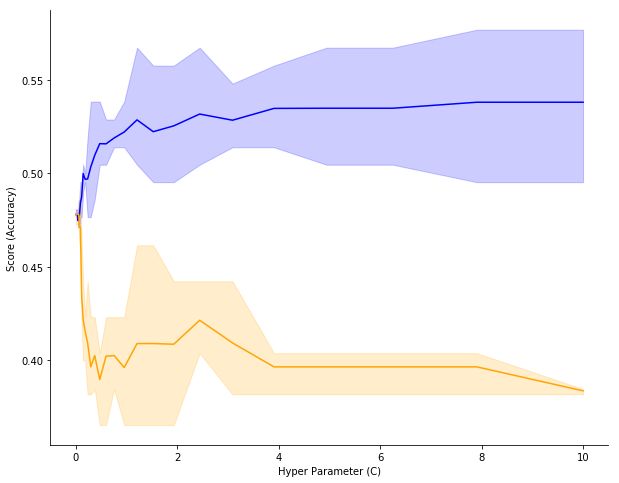

In [34]:
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

clf = LogisticRegression()
clf_pipe = Pipeline(steps=[('poly', PolynomialFeatures(degree=2)), ('norm', MinMaxScaler()), 
                           ('clf', clf)])

param_name='C'
param_range=np.logspace(-4,1, 50)

train_score, test_score = validation_curve(clf_pipe, X_train, y_train, scoring = 'accuracy',
                                           param_name='clf__{}'.format(param_name),
                                           param_range=param_range)

train_max = list(map(np.max, train_score))
train_min = list(map(np.min, train_score))
train_mean = list(map(np.mean, train_score))

test_max = list(map(np.max, test_score))
test_min = list(map(np.min, test_score))
test_mean = list(map(np.mean, test_score))

plt.figure(figsize=(10,8))
for min_val, max_val, mean_val, color, name in zip([train_min, test_min],
                                             [train_max, test_max],
                                             [train_mean, test_mean],
                                             ['blue', 'orange'], 
                                             ['Train Score', 'Test Score']):

    plt.plot(param_range, mean_val, color=color, label=name)
    plt.fill_between(param_range, max_val, min_val, color=color, alpha=0.2)

plt.xlabel('Hyper Parameter ({})'.format(param_name))
plt.ylabel('Score (Accuracy)')
sns.despine()


def multi_class_roc(class_code):

    clf_pipe.fit(X_train, y_train)
    return roc_auc_score(np.where(y_test==class_code, 1,0), 
                  [val[class_code] for val in clf_pipe.predict_proba(X_test)])

print('roc auc score for Company_A = {}'.format(multi_class_roc(0)))
print('roc auc score for Company_B = {}'.format(multi_class_roc(1)))
print('roc auc score for Company_C = {}'.format(multi_class_roc(2)))
print('roc auc score for Company_D = {}'.format(multi_class_roc(3)))
print('average roc auc score = {}'.format(np.mean([multi_class_roc(0),
                                                  multi_class_roc(1),
                                                  multi_class_roc(2),
                                                  multi_class_roc(3)]))) 

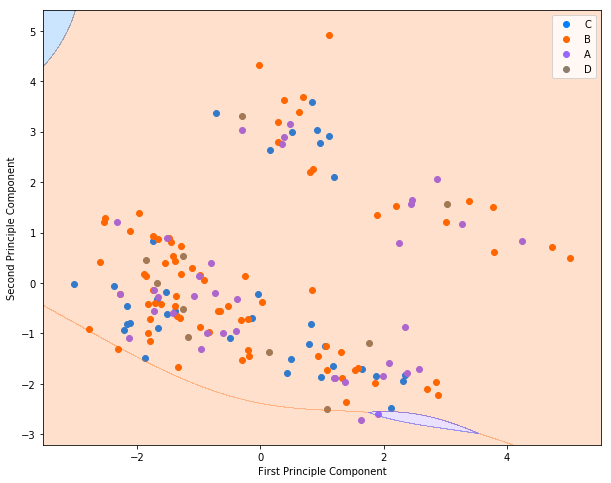

In [36]:
plt.figure(figsize=(10,8))
for group, color, name in zip(frame['Company_'].unique(), ['#0080ff', '#ff6600', '#9966ff','#8B7D6B'], 
                              frame['Company'].unique()):
    pc_group = groups.get_group(group)
    plt.scatter(pc_group.loc[:,'pc_1'], pc_group.loc[:,'pc_2'], color=color, label=name)
plt.legend()

pc_1 = np.array(pc_1)
pc_2 = np.array(pc_2)

pc_1_min = np.min(pc_1) - 0.5
pc_1_max = np.max(pc_1) + 0.5
pc_2_min = np.min(pc_2) - 0.5
pc_2_max = np.max(pc_2) + 0.5

pc_1_ , pc_2_ = np.meshgrid(np.arange(pc_1_min, pc_1_max, 0.0025), 
                            np.arange(pc_2_min, pc_2_max, 0.0025))

clf0 = LogisticRegression(C=15)
clf_pipe0 = Pipeline(steps=[('poly', PolynomialFeatures(degree=3)), ('norm', MinMaxScaler()), 
                           ('clf', clf0)]).fit(pc, y_train)
prediction = clf_pipe0.predict(np.c_[pc_1_.ravel(), pc_2_.ravel()])
prediction = prediction.reshape(pc_1_.shape)

from matplotlib.colors import ListedColormap

cmap=ListedColormap(['#ff6600', '#0080ff', '#9966ff','#8B7D6B'])
plt.contourf(pc_1_, pc_2_, prediction, alpha=0.2, cmap=cmap)
plt.xlabel('First Principle Component')
plt.ylabel('Second Principle Component')